In [1]:
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD

from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

import csv
import sys

Using TensorFlow backend.


In [2]:
width = 160
height = 60
np.set_printoptions(threshold=sys.maxsize)

In [3]:
def preprocess(img):
    new_img = img[300:480, 0:640]
    hsv = cv2.cvtColor(new_img, cv2.COLOR_BGR2HSV)
    lower = np.uint8([83, 0, 0])
    upper = np.uint8([179, 47, 255])
    white_mask = cv2.inRange(hsv, lower, upper)

    result = cv2.bitwise_and(new_img, new_img, mask = white_mask)
#     print(img)
    result = cv2.resize(result, (width, height))
    gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray ,150 ,255, cv2.THRESH_BINARY_INV)
    plt.imshow(thresh)
    
    rgb = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
#     print(rgb.shape)
#     cv2.imshow('thresh',thresh)
#     cv2.waitKey(1)
    return rgb

In [4]:
def get_class(img_path):
#     print(img_path.split('\\')[-2])
    return (img_path.split('\\')[-2])

In [5]:
NUM_CLASSES = 75
try:
    with h5py.File('datasetCNN.h5') as hf:
        X, Y = hf['imgs'][:], hf['labels'][:]
    print("Loaded images from datasetCNN.h5")
    print(X.shape)
    print(Y.shape)
except Exception as e:
    
    imgs = []
    labels = []
    i = 0
    with open('datasetTrain.csv', mode='r', newline = '') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:        
#             print(row["image_name"])
            path = row["image_name"].replace('images', 'imagesTrain')
            img = preprocess(cv2.imread(path))
            imgs.append(img)

            labels.append(row["angle"])
    
    X = np.array(imgs, dtype='uint8')
    #Y = np.eye(NUM_CLASSES, dtype='int')[labels]
    Y = np.array(labels)
#     print(Y)

    encoder = LabelBinarizer()
    #Y = to_categorical(labels)
    Y = encoder.fit_transform(labels)
#     print(Y)
    print(Y.shape)
    with h5py.File('datasetCNN.h5','w') as hf:
        hf.create_dataset('imgs', data=X)
        hf.create_dataset('labels', data=Y)

Loaded images from datasetCNN.h5
(3836, 60, 160, 3)
(3836, 75)


In [6]:

def cnnModel():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(height, width, 3)))
#     model.add(Conv2D(32, (3,3), padding='same',
#                     input_shape=(height, width, 3),
#                     activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
#     model.add(Dense(512, activation='linear'))
    model.add(Dense(256, activation='linear'))
#     model.add(Dropout(0.2))
#     model.add(Dense(128, activation='linear'))
#     model.add(Dense(64, activation='linear'))
    model.add(Dense(NUM_CLASSES))
    return model

In [7]:
model = cnnModel()
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy',
#                   optimizer=sgd,
#                   metrics=['accuracy'])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 60, 160, 3)        12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 158, 8)        224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 79, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 77, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 38, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 36, 32)        4640      
_________________________________________________________________
max_

In [8]:
batch_size = 64
nb_epoch = 30
model.fit(X, Y, batch_size=batch_size, epochs=nb_epoch)
model.save_weights('LaneDetectWeight.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
3836/3836 [==============================] - 5s 1ms/step - loss: 0.0817 - acc: 0.0850
Epoch 2/30
3836/3836 [==============================] - 2s 445us/step - loss: 0.0121 - acc: 0.3180
Epoch 3/30
3836/3836 [==============================] - 2s 435us/step - loss: 0.0105 - acc: 0.4778 0s - loss: 0.0106 - acc: 0.4
Epoch 4/30
3836/3836 [==============================] - 2s 442us/step - loss: 0.0095 - acc: 0.5469
Epoch 5/30
3836/3836 [==============================] - 2s 444us/step - loss: 0.0089 - acc: 0.5769
Epoch 6/30
3836/3836 [==============================] - 2s 436us/step - loss: 0.0085 - acc: 0.6079
Epoch 7/30
3836/3836 [==============================] - 2s 436us/step - loss: 0.0081 - acc: 0.6403
Epoch 8/30
3836/3836 [==============================] - 2s 430us/step - loss: 0.0078 - acc: 0.6621
Epoch 9/30
3836/3836 [==============================] - 2s 432us/step - loss: 0.0075 - acc: 0.6966
Epoch 10/30
3836/3836 [===========

19


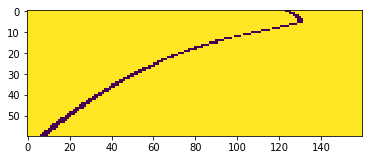

In [9]:
# array_text = [-10, -15, -20, 25, -30, -5, 0, 10, 15, 20, 25, 30, 5]
# array_text = [-44, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24]
test_img = cv2.imread('imagesTest/20.png')
predict_img = preprocess(test_img)
# predict_img = np.array(predict_img, dtype='uint8')
predict_img = np.expand_dims(predict_img, axis=0)
result = model.predict(predict_img)
# print(array_text[result.argmax()])
if result.argmax() == 0:
    print('-44')
elif result.argmax() == 74:
    print('44')
print(result.argmax() - 37)

[ 14  22  22  32  32  32  32  32  28  28  28  28  28  28  28  22  22  22
  20  20  19  21  21  19  19  19  19  19  19  19  19  19  19  22  22  22
  22  22  20  20  22  22  22  22  22  22  21  21  21  20  20  18  16  16
  16  15  10   7   7   7  37  37  37 -37 -37 -34 -34 -15 -15 -15 -33 -33
 -33 -32 -32 -31 -31 -31 -31 -28 -28 -29 -29 -28 -28 -28 -27 -27 -27 -25
 -25 -24 -24 -24 -24 -24 -23 -23 -25 -25 -25 -25 -25 -21 -21 -21 -21 -21
 -23 -23 -23 -23 -23 -19 -19 -19 -19 -19 -19 -19 -19 -19 -19 -19 -19 -19
 -19 -22 -27 -27 -29 -29 -31 -31 -31 -33 -33 -33 -34 -34 -34 -34 -36 -36
 -36  -1  -1  -1  -1  -1  -2  -2  -3  -3  -3  -4  -4  -4  -4  -4  -4  -4
  -4  -4  -4  -4  -4  -4  -4  -4  -4  -4  -4  -4  -4  -4  -4  -4  -4  -4
  -4  -4  -4  -4  -4  -4  -4  -5  -5  -5  -5  -5  -5  -5  -7  -7  -7  -7
  -7  -7  -7 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -15 -26 -26 -26
 -26 -26   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   1
   1   1   1   1  12  12  12  12  12  23  23  23  2

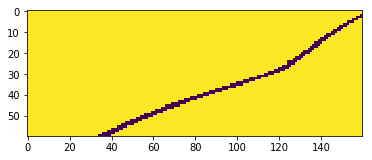

In [10]:
imgs = []
labels = []
i = 0
with open('datasetTest.csv', mode='r', newline = '') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:        
#         print(row["image_name"])
        path = row["image_name"].replace('images', 'imagesTest')
        img = preprocess(cv2.imread(path))
        imgs.append(img)

        labels.append(row["angle"])

X = np.array(imgs, dtype='uint8')
#Y = np.eye(NUM_CLASSES, dtype='int')[labels]
Y = np.array(labels, dtype='int8')
#     print(Y)

y_pred = model.predict_classes(X)
print(y_pred - 37)
print(Y)
acc = np.sum(y_pred-37 == Y)/np.size(y_pred)
print(acc)